In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) #Yadukrishnan - 21BAI1210

/kaggle/lib/kaggle/gcp.py


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from tensorflow.keras.datasets import mnist

In [3]:
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

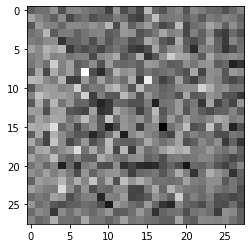

In [4]:
noise = tf.random.normal([1, 100])
generator = define_generator(100)
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
generator.save('/kaggle/output')

In [5]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [6]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [7]:
def load_real_samples():
	(trainX, _), (_, _) = mnist.load_data()
	X = expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

In [8]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

In [9]:
def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [10]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=40, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))


In [12]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

11493376/11490434 [==============================] - 1s 0us/step
>1, 1/234, d=0.687, g=0.724
>1, 2/234, d=0.678, g=0.736
>1, 3/234, d=0.671, g=0.752
>1, 4/234, d=0.671, g=0.764
>1, 5/234, d=0.660, g=0.783
>1, 6/234, d=0.654, g=0.796
>1, 7/234, d=0.652, g=0.807
>1, 8/234, d=0.647, g=0.819
>1, 9/234, d=0.643, g=0.815
>1, 10/234, d=0.641, g=0.813
>1, 11/234, d=0.646, g=0.803
>1, 12/234, d=0.648, g=0.791
>1, 13/234, d=0.651, g=0.771
>1, 14/234, d=0.652, g=0.754
>1, 15/234, d=0.654, g=0.738
>1, 16/234, d=0.651, g=0.727
>1, 17/234, d=0.651, g=0.716
>1, 18/234, d=0.649, g=0.708
>1, 19/234, d=0.645, g=0.702
>1, 20/234, d=0.638, g=0.699
>1, 21/234, d=0.633, g=0.696
>1, 22/234, d=0.630, g=0.694
>1, 23/234, d=0.621, g=0.693
>1, 24/234, d=0.612, g=0.694
>1, 25/234, d=0.605, g=0.693
>1, 26/234, d=0.595, g=0.693
>1, 27/234, d=0.588, g=0.694
>1, 28/234, d=0.579, g=0.695
>1, 29/234, d=0.575, g=0.696
>1, 30/234, d=0.558, g=0.698
>1, 31/234, d=0.554, g=0.699
>1, 32/234, d=0.544, g=0.700
>1, 33/234, d=0.

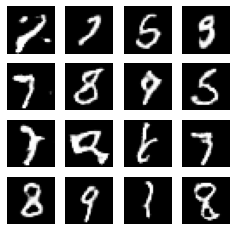

In [13]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
predictions = g_model(seed, training=False)

fig = plt.figure(figsize=(4, 4))
for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] , cmap='gray')
      plt.axis('off')
        
g_model.save('/kaggle/output')

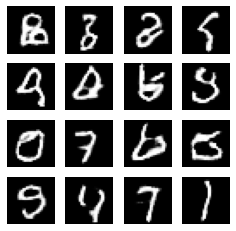

In [14]:
gmdl_new=keras.models.load_model('/kaggle/output')
seed = tf.random.normal([num_examples_to_generate, noise_dim])
predictions = gmdl_new(seed, training=False)

fig = plt.figure(figsize=(4, 4))
for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] , cmap='gray')
      plt.axis('off')
# Yadukrishnan - 21BAI1210